Astrophysis Senior Thesis Code, Fall-Winter 2023-2024
Analyze cl_data.XXXX.continuum.tab output files from TPCI

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import astropy.io.fits

In [2]:
def plot_pretty():
    plt.rcParams['figure.dpi']= 300
    plt.rc('savefig', dpi=300)
    plt.rc('font', size=18)
    plt.rc('axes',labelsize=18,titlesize=16)
    plt.rc('xtick', direction='in',labelsize=16) 
    plt.rc('ytick', direction='in',labelsize=16)
    plt.rc('xtick.major', pad=5) 
    plt.rc('xtick.minor', pad=5)
    plt.rc('ytick.major', pad=5) 
    plt.rc('ytick.minor', pad=5)
    plt.rc('lines', dotted_pattern = [2., 2.])
    plt.rc('figure', titlesize=18)
    plt.tick_params(which='major',length=6, width=1.5,labelsize=16)
    plt.minorticks_on()
    plt.tick_params(which='minor',length=3,width=1)

In [3]:
##### MASTER INPUTS #####

# name of planet ------------------------------------------------------
planet = 'HD209458b' 

# continuum file to analyze ------------------
file = '../hd209458/cl_data.0350.continuum.tab'

# spectra.ini file to use for stellar flux ------------
spectra_file = 'spectra_hd20458.ini'


# PHOENIX files to calculate stellar flux -------------------------
phoenix_wavelengths = 'PHOENIX/WAVE_PHOENIX-ACES-AGSS-COND-2011.fits'

if planet == 'TOI-560b':
    phoenix_spectrum = 'PHOENIX/lte04500-4.50-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits'

elif planet == 'WASP-69b':
    phoenix_spectrum = 'PHOENIX/lte04700-4.50-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits'

elif planet == 'TOI-1430b' or 'HD189733b':
    phoenix_spectrum = 'PHOENIX/lte05000-4.50-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits'

elif planet == 'HD209458b':
    phoenix_spectrum = 'PHOENIX/lte06000-4.50-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits'


# CL output mode for continua: 'intensity' or 'luminosity'
CLOUDY_mode = 'intensity' 


# CONSTANTS -----------------------------
# CGS unless specified

AU = 1.496e13
c = 3e10
pc = 3.086e18

# [ergs*s]
h = 6.626e-34 * 1e7
kB = 1.38e-23 * 1e7

# [A/cm]
Angstrom = 1e8

# Solar
L_S = 3.83e33
M_S = 1.988e33
R_S = 6.957e10

# Earth
M_E = 5.97e27
R_E = 6.371e8

In [4]:
##### INPUT VALUES FOR PLANET #####

# Lyman-alpha flux given at 1AU from star

# # TOI560b ---------------------
# STAR
# star_mass = 0.75 * M_S
# star_radius = 0.65 * R_S
# star_lum = 0.1831 * L_S 
# star_temperature = 4500
# lyman_flux = 15
# dist = 31.6 * pc

# # PLANET 
# a = 0.0596 * AU
# planet_mass = 11 * M_E
# planet_radius = 2.9 * R_E
# planet_temp = 740
# -----------------------------



# HD 209458b ------------------
# STAR
star_mass = 1.069 * M_S
star_radius = 1.20 * R_S
star_lum = 1.701 * L_S
star_temperature = 6026
lyman_flux = 21
dist = 48.3 * pc

# PLANET 
a = 0.04634 * AU
planet_mass = 219 * M_E
planet_radius = 15.1 * R_E
planet_temp = 1320 # Qiao 
# -----------------------------



# HD189733b -------------------
# STAR
# star_mass = 0.84 * M_S
# star_radius = 0.775 * R_S
# star_lum = 0.3458 * L_S
# star_temperature = 5012
# lyman_flux = 15
# dist = 19.76 * pc

# # PLANET 
# a = 0.031 * AU
# planet_mass = 370 * M_E
# planet_radius = 12.7 * R_E
# planet_temp = 1200
# -----------------------------
 


# WASP-69b -------------------
# STAR
# star_mass = 0.76 * M_S
# star_radius = 0.813 * R_S
# star_lum = 0.355 * L_S
# star_temperature = 4715
# lyman_flux = 10
# dist = 49.96 * pc

# # PLANET 
# a = 0.045 * AU
# planet_mass = 92 * M_E
# planet_radius = 12.4 * R_E
# planet_temp = 963
# -----------------------------



# TOI-1430b -------------------
# STAR
# star_mass = 0.84 * M_S
# star_radius = 0.789 * R_S
# star_lum = 0.361 * L_S
# star_temperature = 5037
# lyman_flux = 23
# dist = 41.17 * pc

# # PLANET 
# a = 0.072 * AU
# planet_mass = 7 * M_E
# planet_radius = 2.04 * R_E
# planet_temp = 800
# -----------------------------




'\n# TOI-1430b -------------------\n# STAR\nstar_mass = 0.84 * M_S\nstar_radius = 0.789 * R_S\nstar_lum = 0.361 * L_S\nstar_temperature = 5037\nlyman_flux = 23\ndist = 41.17 * pc\n\n# PLANET \na = 0.072 * AU\nplanet_mass = 7 * M_E\nplanet_radius = 2.04 * R_E\nplanet_temp = 800\n# -----------------------------\n'

In [5]:
df = pd.read_table(file)

# refer to CLOUDY'S HAZY documentation section 15.42.6 "Save continuum predictions"
# units are for "luminosity case"
# we mostly care about photon's 'wavelength' energy [Angstroms] and outward emitted continuum+line emission 'em_cont'

column_labels = ['wavelength', 'inc_cont', 'trans_inc_cont', 'em_cont', 'trans_cont',
                 'refl_cont', 'trans_refl_cont', 'refl_em', 'out_em', '1st_line', '2nd_line', 'num_lines_E']

df.columns = column_labels

In [6]:
# Find continuum fluxes

# [A] -> [cm]
wavelength = df['wavelength'] / Angstrom
wavelength = wavelength.to_numpy()


# find photon energy, E = hν
photon_energy = (h*c) / wavelength # [ergs]
freq = photon_energy / h # [Hz]


# Luminosity case in TPCI--continuum values 'em_cont' =  ν*L_ν/4πr_o^2 [erg/cm2*s]
if CLOUDY_mode == 'luminosity':
    # dν/dλ = c/(λ^2) for converting L_ν to L_λ
    photon_flux_Earth = df['em_cont']/freq * (c/(wavelength**2)) * (planet_radius/dist)**2 / photon_energy # [ergs/s*cm2] -> [photons/cm2*s*cm]

    # energy flux at 1AU in system
    energy_flux_1AU = photon_flux_Earth * (dist/AU)**2 * photon_energy # [ergs/cm2*s*cm]


# Intensity case--continuum mean intensity (per sr) per octave 'em_cont' = 4π*ν*J_ν [ergs/(cm^2 * s)]
elif CLOUDY_mode == 'intensity':
    # spectral radiance J_ν [ergs/(sr s cm^2 Hz)]
    photon_flux_Earth = df['em_cont']/freq * (c/(wavelength**2)) * (planet_radius/dist)**2 / photon_energy # [ergs/s*cm^2] -> [photons/cm^2*s*cm]

    energy_flux_1AU = photon_flux_Earth * (dist/AU)**2 * photon_energy # [ergs/cm2*s*cm]


In [7]:
# emission line wavelengths [cm]

# Lyman-alpha
Lya = 1215.67 / Angstrom

# Hydrogen alpha
Ha = 6560 / Angstrom

# metastable He 1083nm
He = 10833 / Angstrom

In [8]:
# information to calculate and display peak value for various spectral lines

def line_val(line_wave, mode, wavelength_bin=200):
    ''' Input spectral line (cm), calculate peak value of
        mode="photon": photon flux @ Earth;
        mode="flux": energy flux @ 1AU in system'''
    
    # should contain two wavelength bins of λ/200 each for TPCI data
    bin_width = wavelength / wavelength_bin 
    cond = (wavelength >= line_wave - bin_width) & (wavelength <= line_wave + bin_width)

    if mode == 'photon':
        calc = photon_flux_Earth

    elif mode == 'flux':
        calc = energy_flux_1AU

    elif mode == 'Lya':
        return np.max(energy_flux_1AU[cond])

    # TPCI value is average across each bin
    area = np.sum((calc * bin_width)[cond])

    return area
    

def plot_specline(line, mode):
    ''' Plot spectral line (input in cm) on flux graph (in A)
        Add label with peak calculated flux'''
    
    colors = {Ha:'r', He:'orange', Lya:'violet'}
    latex = {Ha: r'$H\alpha$', He: r'$He*$', Lya: r'$Ly\alpha$'}

    peak = ' {:.2e}'.format(line_val(line, mode))
    ax.axvline(line*Angstrom, c=colors[line], ls='--',label=latex[line]+peak, zorder=-1)

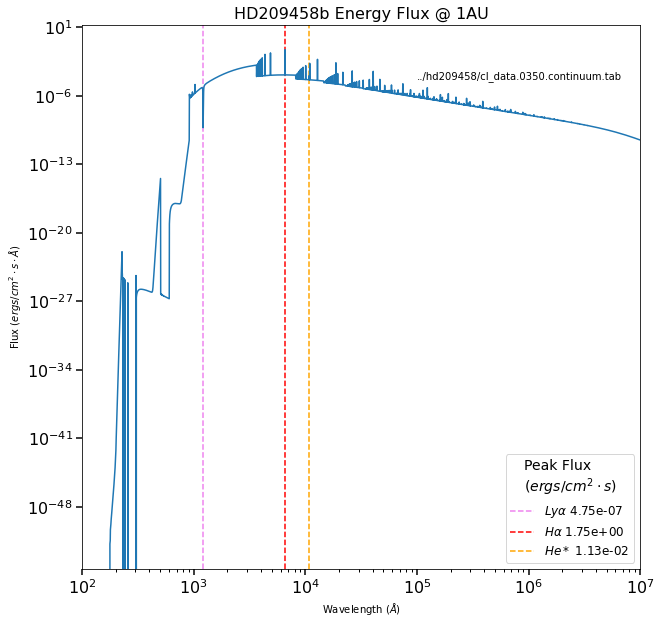

In [9]:
# Plot wavelength continuum vs calculated flux

# INPUT VARIABLES -------------------
mode = 'flux'
lines = [Lya, Ha, He]


fig,ax = plt.subplots(1,1, figsize=(10,10))
ax.set_xscale('log'), ax.set_yscale('log')

ax.set_xlim(1e2, 1e7)

plot_pretty()
ax.minorticks_on()
ax.yaxis.remove_overlapping_locs = False

# plot photon or energy flux
if mode == 'photon':
    ax.plot(df['wavelength'],photon_flux_Earth/Angstrom, lw=1.5)
    ax.set_ylim(1e-16,)

    ax.set_ylabel(r'Flux ($N_{\gamma}/{cm^2 \cdot s \cdot \AA})$')
    ax.set_title(planet + ' Photon Flux @ Earth')
    legtext = r'$(N_{\gamma}/{cm^2 \cdot s})$'

elif mode == 'flux':
    ax.plot(df['wavelength'], energy_flux_1AU/Angstrom, lw=1.5)
    #ax.set_ylim(1e-14,)

    ax.set_ylabel(r'Flux ($ergs/{cm^2 \cdot s \cdot \AA})$')
    ax.set_title(planet + ' Energy Flux @ 1AU')
    legtext = r'$(ergs/{cm^2 \cdot s})$'

# plot spectral lines+peak values
for line in lines:
    plot_specline(line, mode)


ax.set_xlabel(r'Wavelength ($\AA$)')
plt.text(0.60, 0.9, file, fontsize=10, transform=ax.transAxes)
ax.legend(loc='lower right', title='Peak Flux\n' + legtext,title_fontsize=14, fontsize=12)

In [10]:
# Planck's Law Blackbody Radiation Formula

def blackbody_emission(wavelength, temperature):
    ''' Calculate spectral exitance M(T, λ) for a certain wavelength
        Integrate standard Planck's function B(T, λ) over solid angle -> B*π
        All constants and inputs in CGS! [cm], [K]
        Output in [ergs/(s * cm^2 * cm)]
    '''

    # spectral radiance per wavelength
    B = ((2*h*c**2) / wavelength**5) * (np.exp((h*c)/(kB*wavelength*temperature)) - 1)**(-1)

    # Lambert's cosine law
    M = np.pi*B

    return M

In [11]:

def stellar_line_flux(wavelength, wavelength_bin):
    ''' Calculate stellar energy emission of a spectral line (at star's surface -> 1AU)
        wavelength [cm]: line we want photon flux for
        phoenix_spectrum, phoenix_wavelengths: FITS files of hi-res PHOENIX stellar spectra, defined above
        PHOENIX regime of [5, 55000] Angstroms

        Returns: flux [ergs/(s * cm^2)] @ 1AU
                UNLESS wavelength='Lya', in which case it returns Lyman alpha line amplitude
        '''

    # calculate area via PHOENIX spectra if in its regime   
    if wavelength >= 1300/Angstrom and wavelength <= 55000/Angstrom:
    
        # wavelength data [Angstroms] -> [cm]
        hdul_wave = astropy.io.fits.open(phoenix_wavelengths)
        wavelength_grid = hdul_wave[0].data / Angstrom
        hdul_wave.close()

        # flux data [ergs/(s * cm^2 * cm)]
        hdul = astropy.io.fits.open(phoenix_spectrum)
        spectrum = hdul[0].data
        hdul.close()

        bin_width = wavelength_grid / wavelength_bin 

        cond = (wavelength_grid >= wavelength - bin_width) & (wavelength_grid <= wavelength + bin_width)

        print('bin amount = ', len(spectrum[cond]))
        
        area = np.trapz(spectrum[cond], wavelength_grid[cond]) * (star_radius / AU)**2
        return area

    # find ratio between stellar and planet Ly-a fluxes directly for SNR
    # NOT integrating area here!
    elif wavelength == Lya:
        # from Salz spectrum notebook [ergs/(s * cm2 * A)]
        A = lyman_flux / (np.sqrt(2*np.pi) * (9.4/2.355))
        return A
    
    
    # read data from provided spectra.ini file
    else:

        df = pd.read_csv(spectra_file, sep=' ', names=['logfreq', 'logflux'], usecols=[1,2], skiprows=1, skipfooter=1)

        wavelength_grid = c / (10**df['logfreq']) # [cm]
        wavelength_grid = wavelength_grid.to_numpy()
        
        flux_1AU = (10**df['logflux']) * c/(wavelength_grid**2) # [ergs/(s * cm2 * cm)]
        flux_1AU = flux_1AU.to_numpy()

        bin_width = wavelength_grid / wavelength_bin 
        
        cond = (wavelength_grid >= wavelength - bin_width) & (wavelength_grid <= wavelength + bin_width)

        print('bin amount = ', len(flux_1AU[cond]))
        
        area = -1*np.trapz(flux_1AU[cond], wavelength_grid[cond]) # more consistent with PHOENIX calc method

        return area


In [12]:
def line_SNR(wavelength, F_star, mode='custom', params=None):
    ''' Calculate signal-to-noise ratio of an emitted spectral line
        S/N = num of photons for planet flux / total flux ~ planet flux / stellar flux

        wavelength [cm]: line we want SNR for
        F_star [ergs/(s * cm^2)]: flux at 1AU for the line, generate using stellar_line_flux
        params: dictionary of input parameters (if 'custom')
            {mirror radius [cm], integration time [s], wavelength bin [lambda/num], instrument SNR [/spectral px in 60s]}
        mode: select instrument setup, 'keck' or 'custom' (if using custom input dict)


        Dependent values: {h, c, kB}, star_radius, dist'''


    # parameter values for certain telescopes+instruments
    if mode.lower() == 'keck':
        mirror_area = np.pi * (500)**2

        if wavelength == He:
            throughput = 0.10 # NIRSPEC, binsize 110,000

        elif wavelength == Ha:
            throughput = 0.10 # KPF, binsize 343,000 
    

    elif mode.lower() == 'hubble' or wavelength == Lya:
        mirror_area = np.pi * (120)**2
        throughput = [0.005,0.012] # STIS E140H & G140M, binsizes 228,000 & 24,300

    print('mode = ', mode.upper())
    print('throughput = ', throughput)
    
    # photon flux at Earth for planet
    F_photon_planet = line_val(wavelength, 'photon')
    k2 = (planet_radius/star_radius)**2

    # simply find SNR as eclipse depth--ratio of Lya peak amplitudes
    if wavelength == Lya:
        # [ergs/(s * cm2 * A)]       
        stellar_Lya_amplitude = F_star
        planet_Lya_amplitude = line_val(Lya, 'Lya')

        SNR = (planet_Lya_amplitude/stellar_Lya_amplitude) * np.sqrt(throughput)

        # secondary/occultation eclipse depth
        eclipse_depth = k2 * (planet_Lya_amplitude/stellar_Lya_amplitude)

    else:
        # photon flux at Earth per photon times wavelength bin
        F_photon_star = F_star * (AU / dist)**2  / (h*c/wavelength)


        # assuming transit duration T=2hr
        T_dur = 2*3600
        sigma_star = np.sqrt(F_photon_star * mirror_area * T_dur)

        # taking flux difference (planet = measured - star) adds factor of sqrt(2)
        err_planet = np.sqrt(2) / sigma_star
        
        # SNR = mean/sigma * sqrt(throughput)
        SNR = (F_photon_planet * mirror_area * T_dur) * err_planet * np.sqrt(throughput)

        # secondary/occultation eclipse depth
        eclipse_depth = k2 * (F_photon_planet/F_photon_star)

    # SNR = 5 for strong detection, 2 for weak
    return SNR, eclipse_depth



In [13]:
def run_calcs(line):
    '''Wrapper to run SNR and eclipse depth calculations on a given wavelength [cm]
        Returns: SNR, eclipse_depth'''
    
    if line == Lya:
        # run for Hubble STIS E and G both
        for i, b in enumerate([228000, 24300]):
            grism = ['STIS E', 'STIS G']
            stellar_line = stellar_line_flux(line, wavelength_bin=b)
            print(f'Lya amplitude = {stellar_line:.2e}')
            print(grism[i])
            
            SNR1, eclipse_depth = line_SNR(line, stellar_line, mode='hubble')
            if b == 228000:
                SNR = SNR1[0]
            else:
                SNR = SNR1[1]
            print(f'SNR = {SNR:.4f}')
            print(f'eclipse depth = {eclipse_depth:.8e}\n')    


    elif line == Ha:
        # run for Keck KPF
        stellar_line = stellar_line_flux(line, 343000)
        print(f'Ha flux = {stellar_line:.2e}')

        SNR, eclipse_depth = line_SNR(line, stellar_line, mode='keck')

    elif line == He:
        # run for Keck NIRSPEC
        stellar_line = stellar_line_flux(line, 110000)

        print(f'He flux = {stellar_line:.2e}')
        SNR, eclipse_depth = line_SNR(line, stellar_line, mode='keck')

    else:
        SNR, eclipse_depth = 0, 0
        print('Error: enter known line wavelength')

    print(f'SNR = {SNR:.4f}')
    print(f'eclipse depth = {eclipse_depth:.8e}\n')
    return SNR, eclipse_depth


In [14]:
lines = [Lya, Ha, He]
for line in lines:
    run_calcs(line)

Lya amplitude = 2.10e+00
STIS E
mode =  HUBBLE
throughput =  [0.005, 0.012]
SNR = 0.2099
eclipse depth = 3.94225724e-02

Lya amplitude = 2.10e+00
STIS G
mode =  HUBBLE
throughput =  [0.005, 0.012]
SNR = 0.3252
eclipse depth = 3.94225724e-02

SNR = 0.3252
eclipse depth = 3.94225724e-02

bin amount =  3
Ha flux = 2.35e+00
mode =  KECK
throughput =  0.1
SNR = 2211.5729
eclipse depth = 9.88389465e-03

bin amount =  9
He flux = 9.43e+00
mode =  KECK
throughput =  0.1
SNR = 9.1374
eclipse depth = 1.58537975e-05

